In [1]:
import pandas as pd
import numpy as np
import os
import collections
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer

from keras_preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential, load_model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
plt.style.use('bmh')

import warnings
warnings.filterwarnings('ignore')

In [2]:
fileList = os.listdir('../data/cleaned_files')

###### Loading frequent words for exclusion

In [3]:
exlusionList = pd.read_excel('../data/exclusion_list.xlsx')
frequentWords = list(exlusionList['word1']) + stopwords.words('english')

###### Reading scrapped scripts

In [4]:
scripts = []
movieTitles = []
for i in fileList:
    ### Reading Data
    with open('../data/cleaned_files/'+i, encoding="utf-8") as f:
        text = f.readlines()
        movieTitles.append(i.replace('.txt.txt', '').replace('-', ' '))
        scripts.append(text[0])

In [5]:
len(scripts)

756

###### Script Df

In [6]:
scriptDf = pd.DataFrame({'title': movieTitles, 'script':scripts})

In [7]:
scriptDf.head()

,title,script
0,10 Things I Hate About You,ten thing hate karen mccullah lutz kirsten smi...
1,12 and Holding,holding written anthony cipriano fade ext neig...
2,12 Monkeys,twelve monkey twelve monkey original screenpla...
3,12 Years a Slave,year slave written john ridley card fade int t...
4,12,scriptcut blacktitle finexterior dayfin red ch...


###### Loading movie metadata

In [8]:
movieMetaData = pd.read_csv('../data/kaggle/IMDB_parental_guide.csv')
### Selecting only movies
movieMetaData = movieMetaData[movieMetaData['titleType'] == 'movie']

movieMetaData.head()

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,genres,averageRating,numVotes,...,profanity,drugs,intense,sex_code,violence_code,profanity_code,drug_code,intense_code,mpaa,certificate
0,tt0111161,movie,The Shawshank Redemption,The Shawshank Redemption,0,1994,142.0,Drama,9.3,2684158,...,Severe,Mild,Moderate,2.0,3.0,4.0,2.0,3.0,Rated R for language and prison violence,Argentina:16 (original rating)|Argentina:13 (r...
1,tt0468569,movie,The Dark Knight,The Dark Knight,0,2008,152.0,"Action,Crime,Drama",9.0,2657541,...,Mild,Mild,Severe,1.0,3.0,2.0,2.0,4.0,Rated PG-13 for intense sequences of violence ...,Argentina:13|Australia:M|Austria:14|Austria:14...
2,tt1375666,movie,Inception,Inception,0,2010,148.0,"Action,Adventure,Sci-Fi",8.8,2357063,...,Mild,Mild,Moderate,1.0,3.0,2.0,2.0,3.0,Rated PG-13 for sequences of violence and acti...,Argentina:13|Australia:M|Austria:12|Brazil:14|...
3,tt0137523,movie,Fight Club,Fight Club,0,1999,139.0,Drama,8.8,2129710,...,Severe,Moderate,Severe,3.0,4.0,4.0,3.0,4.0,Rated R for disturbing and graphic depiction o...,Argentina:18|Australia:R18+|Australia:MA15+ (t...
5,tt0109830,movie,Forrest Gump,Forrest Gump,0,1994,142.0,"Drama,Romance",8.8,2083211,...,Moderate,Moderate,Moderate,3.0,3.0,3.0,3.0,3.0,"Rated PG-13 for drug content, some sensuality ...",Argentina:13|Australia:M|Brazil:14|Canada:PG (...


###### Mapping scripts with metadata

In [9]:
movieMetaData.columns

Index(['tconst', 'titleType', 'primaryTitle', 'originalTitle', 'isAdult',
       'startYear', 'runtimeMinutes', 'genres', 'averageRating', 'numVotes',
       'sex', 'violence', 'profanity', 'drugs', 'intense', 'sex_code',
       'violence_code', 'profanity_code', 'drug_code', 'intense_code', 'mpaa',
       'certificate'],
      dtype='object')

In [10]:
finalDf = pd.merge(movieMetaData, scriptDf, how ='inner', left_on=['primaryTitle'], right_on = ['title'])

###### Missing values

In [11]:
missingValues = pd.DataFrame({'variable':finalDf.isna().sum().index, 'missing values': finalDf.isna().sum()*100/finalDf.shape[0]})

In [12]:
missingValues[missingValues['missing values'] != 0]

,variable,missing values
sex,sex,5.357143
violence,violence,6.473214
profanity,profanity,6.026786
drugs,drugs,6.696429
intense,intense,6.919643
sex_code,sex_code,5.357143
violence_code,violence_code,6.473214
profanity_code,profanity_code,6.026786
drug_code,drug_code,6.696429
intense_code,intense_code,6.919643


In [13]:
### Replacing missing values with None
finalDf = finalDf.fillna('None')

###### Getting tfidf values for corpus

In [14]:
vectorizer = TfidfVectorizer()
transData = vectorizer.fit_transform(finalDf['script'])

In [15]:
tfidf = vectorizer.transform(finalDf['script'])
df = pd.DataFrame(tfidf.toarray(), columns = vectorizer.get_feature_names())

In [16]:
#tfidfData = pd.DataFrame({'': df.mean().index, '': df.mean()})
#tfidfData.to_excel('../outputs/tfid.xlsx')

###### Getting the distribution of parent guide profile

In [17]:
ratingList = ['sex', 'violence', 'profanity', 'drugs', 'intense']
segmentList = ['None', 'Moderate', 'Mild', 'Severe']

In [18]:
finalDf.sex.unique()

array(['None', 'Moderate', 'Mild', 'Severe'], dtype=object)

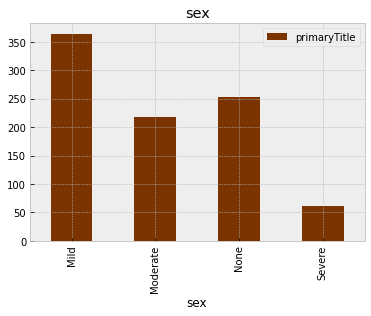

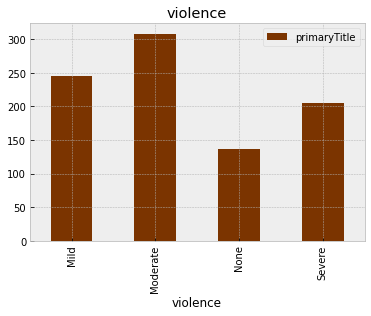

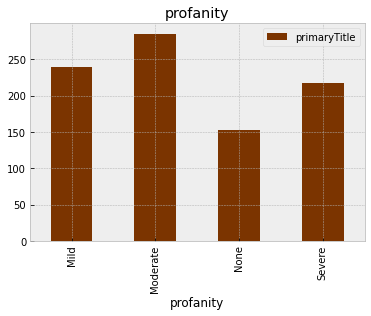

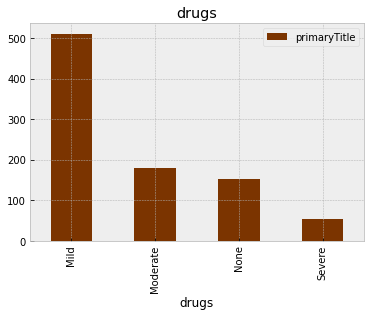

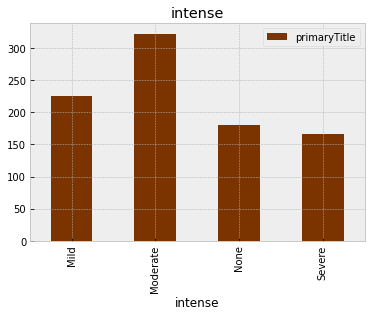

In [19]:
for i in ratingList:
    finalDf.groupby([i], as_index = False).count()[[i, 'primaryTitle']].plot.bar(x=i, y='primaryTitle', color = '#7B3400', title=i)
    plt.show()

###### Extracting very frequent words

In [21]:
totalText = ' '.join(finalDf['script'])
for i in frequentWords:
    totalText = totalText.replace(' ' + i + ' ', ' ')
textList = totalText.split(' ')
counter=collections.Counter(textList)

### Creating dataframe
w1 = []
value = [] 
for i,j in zip(list(counter), list(counter.values())) :
    w1.append(i)
    value.append(j)

In [22]:
uniGramdf = pd.DataFrame({'word1': w1, 'freq': value}).sort_values(['freq'], ascending = False)

In [23]:
uniGramdf.head(20)

,word1,freq
615,arm,13416
54,gun,12288
1213,life,11975
288,black,11902
435,grab,11637
2124,body,9828
578,hit,9590
485,dead,9289
287,fall,9044
766,hell,8699


In [24]:
#uniGramdf.to_excel('../outputs/frequentwords_v2.xlsx')

###### Frequent bi-grams

In [25]:
counter=collections.Counter(nltk.bigrams(textList))

### Bigram df
w1 = []
w2 = []
value = [] 
for i,j in zip(list(counter), list(counter.values())) :
    w1.append(i[0])
    w2.append(i[1])
    value.append(j)

bigramDf = pd.DataFrame({'word1': w1, 'word2': w2, 'freq': value}).sort_values(['freq'], ascending = False)

In [26]:
bigramDf.head(10)

,word1,word2,freq
19516,high,school,1063
34,security,guard,876
17195,deep,breath,825
12615,late,afternoon,809
409981,tin,cup,744
15894,leave,alone,639
6599,jesus,christ,611
13209,police,station,610
205,lean,forward,601
19467,police,officer,599


###### Word Cloud

- SEX

None


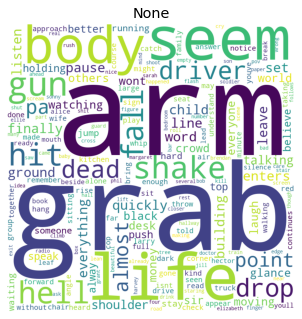

Moderate


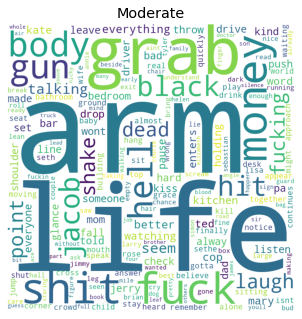

Mild


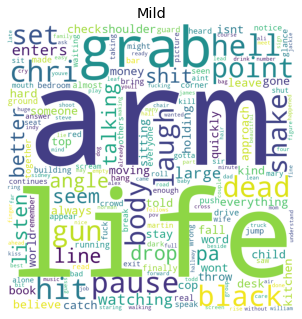

Severe


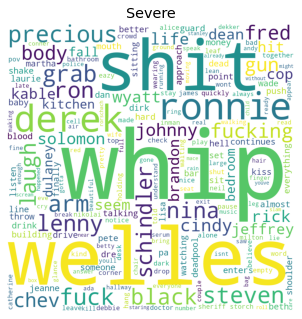

In [27]:
for i in segmentList:
    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    stopwords = set(STOPWORDS.union(set(frequentWords))),
                    min_font_size = 10).generate(' '.join(finalDf[finalDf['sex'] == i]['script']))

    # plot the WordCloud image
    print(i)
    plt.figure(figsize = (4, 4), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.title(i)
    plt.show()

In [28]:
sexBiDf = pd.DataFrame()

for seg in segmentList:
    totalText = ' '.join(finalDf[finalDf['sex'] == seg]['script'])
    for fw in frequentWords:
        totalText = totalText.replace(' ' + fw + ' ', ' ')
    textList = totalText.split(' ')
    
    counter=collections.Counter(nltk.bigrams(textList))

    ### Bigram df
    w1 = []
    w2 = []
    value = [] 
    for i,j in zip(list(counter), list(counter.values())) :
        w1.append(i[0])
        w2.append(i[1])
        value.append(j)

    bigramDf = pd.DataFrame({'word1': w1, 'word2': w2, 'freq': value}).sort_values(['freq'], ascending = False)
    bigramDf['sex'] = seg
    sexBiDf = pd.concat([sexBiDf, bigramDf[0:100]], axis = 0)

In [29]:
sexBiDf

,word1,word2,freq,sex
435188,master,mind,474,None
1207669,lord,mansfield,472,None
1229297,tenzin,gyatso,371,None
132633,bernie,rose,314,None
1336950,crow,horse,309,None
...,...,...,...,...
297774,rain,precious,38,Severe
15739,kiss,cheek,38,Severe
349138,ronnie,brandi,37,Severe
95279,crash,site,37,Severe


In [30]:
sexBiDf.shape

(400, 4)

In [31]:
sexBiDf.to_excel('../outputs/sex_bigram.xlsx')

In [32]:
ratingList

['sex', 'violence', 'profanity', 'drugs', 'intense']

###### violence

None


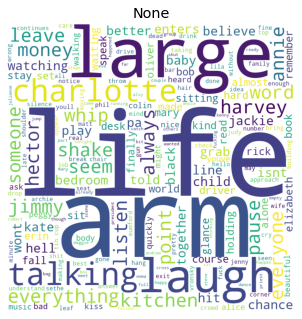

Moderate


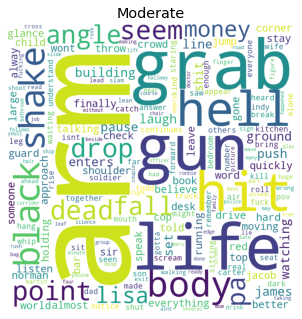

Mild


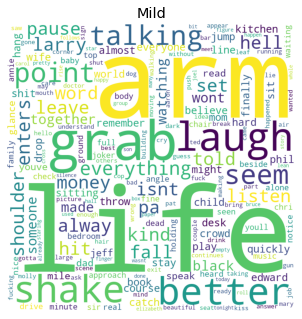

Severe


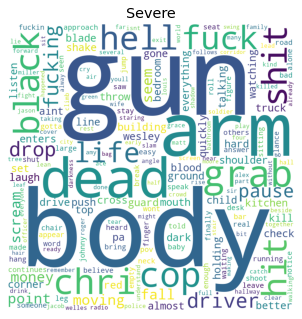

In [30]:
for i in segmentList:
    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    stopwords = set(STOPWORDS.union(set(frequentWords))),
                    min_font_size = 10).generate(' '.join(finalDf[finalDf['violence'] == i]['script']))

    # plot the WordCloud image
    print(i)
    plt.figure(figsize = (4, 4), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.title(i)
    plt.show()

In [ ]:
sexBiDf = pd.DataFrame()

for seg in segmentList:
    totalText = ' '.join(finalDf[finalDf['violence'] == seg]['script'])
    for fw in frequentWords:
        totalText = totalText.replace(' ' + fw + ' ', ' ')
    textList = totalText.split(' ')
    
    counter=collections.Counter(nltk.bigrams(textList))

    ### Bigram df
    w1 = []
    w2 = []
    value = [] 
    for i,j in zip(list(counter), list(counter.values())) :
        w1.append(i[0])
        w2.append(i[1])
        value.append(j)

    bigramDf = pd.DataFrame({'word1': w1, 'word2': w2, 'freq': value}).sort_values(['freq'], ascending = False)
    bigramDf['violence'] = seg
    sexBiDf = pd.concat([sexBiDf, bigramDf[0:100]], axis = 0)
    
sexBiDf.to_excel('../outputs/violence_bigram.xlsx')

###### profanity

None


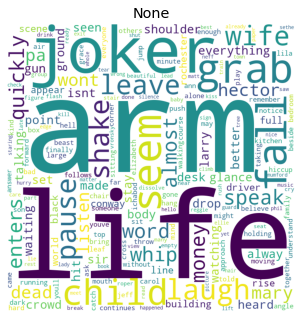

Moderate


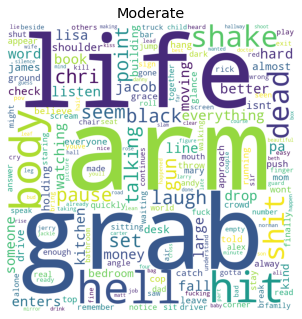

Mild


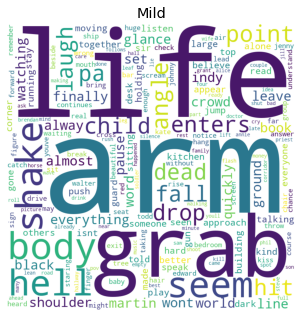

Severe


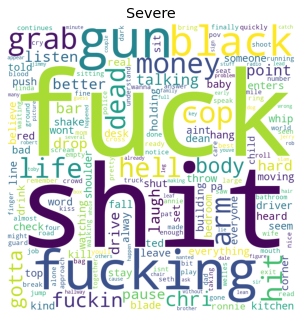

In [31]:
for i in segmentList:
    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    stopwords = set(STOPWORDS.union(set(frequentWords))),
                    min_font_size = 10).generate(' '.join(finalDf[finalDf['profanity'] == i]['script']))

    # plot the WordCloud image
    print(i)
    plt.figure(figsize = (4, 4), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.title(i)
    plt.show()

In [ ]:
sexBiDf = pd.DataFrame()

for seg in segmentList:
    totalText = ' '.join(finalDf[finalDf['profanity'] == seg]['script'])
    for fw in frequentWords:
        totalText = totalText.replace(' ' + fw + ' ', ' ')
    textList = totalText.split(' ')
    
    counter=collections.Counter(nltk.bigrams(textList))

    ### Bigram df
    w1 = []
    w2 = []
    value = [] 
    for i,j in zip(list(counter), list(counter.values())) :
        w1.append(i[0])
        w2.append(i[1])
        value.append(j)

    bigramDf = pd.DataFrame({'word1': w1, 'word2': w2, 'freq': value}).sort_values(['freq'], ascending = False)
    bigramDf['profanity'] = seg
    sexBiDf = pd.concat([sexBiDf, bigramDf[0:100]], axis = 0)
    
sexBiDf.to_excel('../outputs/profanity_bigram.xlsx')

###### drugs

None


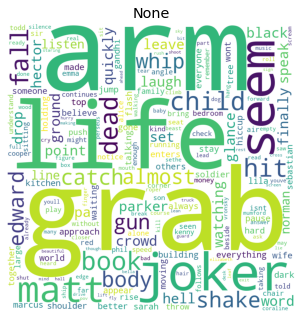

Moderate


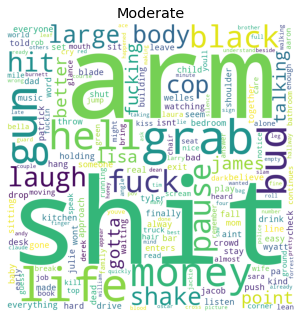

Mild


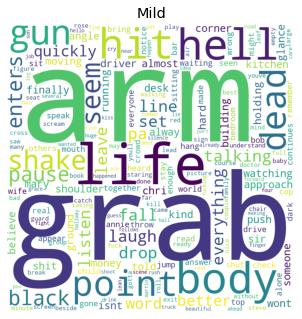

Severe


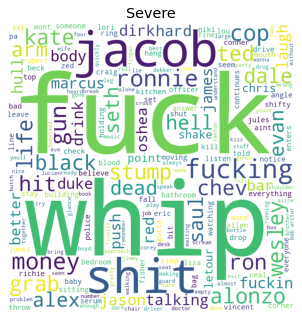

In [32]:
for i in segmentList:
    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    stopwords = set(STOPWORDS.union(set(frequentWords))),
                    min_font_size = 10).generate(' '.join(finalDf[finalDf['drugs'] == i]['script']))

    # plot the WordCloud image
    print(i)
    plt.figure(figsize = (4, 4), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.title(i)
    plt.show()

In [ ]:
sexBiDf = pd.DataFrame()

for seg in segmentList:
    totalText = ' '.join(finalDf[finalDf['drugs'] == seg]['script'])
    for fw in frequentWords:
        totalText = totalText.replace(' ' + fw + ' ', ' ')
    textList = totalText.split(' ')
    
    counter=collections.Counter(nltk.bigrams(textList))

    ### Bigram df
    w1 = []
    w2 = []
    value = [] 
    for i,j in zip(list(counter), list(counter.values())) :
        w1.append(i[0])
        w2.append(i[1])
        value.append(j)

    bigramDf = pd.DataFrame({'word1': w1, 'word2': w2, 'freq': value}).sort_values(['freq'], ascending = False)
    bigramDf['drugs'] = seg
    sexBiDf = pd.concat([sexBiDf, bigramDf[0:100]], axis = 0)
    
sexBiDf.to_excel('../outputs/drugs_bigram.xlsx')

###### intense

None


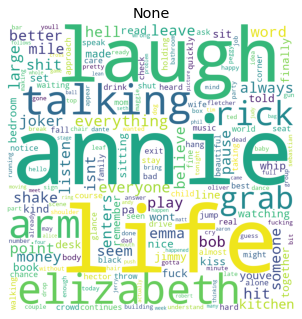

Moderate


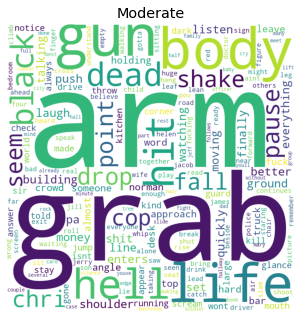

Mild


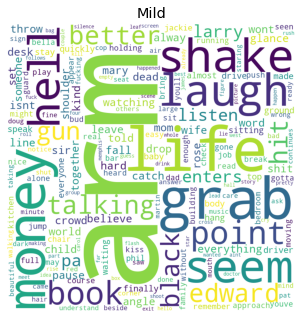

Severe


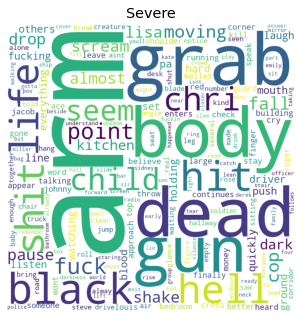

In [33]:
for i in segmentList:
    wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    stopwords = set(STOPWORDS.union(set(frequentWords))),
                    min_font_size = 10).generate(' '.join(finalDf[finalDf['intense'] == i]['script']))

    # plot the WordCloud image
    print(i)
    plt.figure(figsize = (4, 4), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.title(i)
    plt.show()

In [ ]:
sexBiDf = pd.DataFrame()

for seg in segmentList:
    totalText = ' '.join(finalDf[finalDf['intense'] == seg]['script'])
    for fw in frequentWords:
        totalText = totalText.replace(' ' + fw + ' ', ' ')
    textList = totalText.split(' ')
    
    counter=collections.Counter(nltk.bigrams(textList))

    ### Bigram df
    w1 = []
    w2 = []
    value = [] 
    for i,j in zip(list(counter), list(counter.values())) :
        w1.append(i[0])
        w2.append(i[1])
        value.append(j)

    bigramDf = pd.DataFrame({'word1': w1, 'word2': w2, 'freq': value}).sort_values(['freq'], ascending = False)
    bigramDf['intense'] = seg
    sexBiDf = pd.concat([sexBiDf, bigramDf[0:100]], axis = 0)
    
sexBiDf.to_excel('../outputs/intense_bigram.xlsx')

## RNN Model - Violence prediction

In [20]:
from keras_preprocessing import text, sequence

vocab = set(word.lower() for script in finalDf['script'] for word in script.split(' '))

In [42]:
# Dummy coding violence
targetVar = finalDf['violence']
y = pd.get_dummies(targetVar).values

# Word tokenization using keras
tokenizer = text.Tokenizer(num_words=20000)  # limit to the num_words most important ones
tokenizer.fit_on_texts(list(finalDf['script']))
#tk.texts_to_matrix(texts, mode='tfidf')
tokenized_texts = tokenizer.texts_to_sequences(finalDf['script'])
X = sequence.pad_sequences(tokenized_texts, maxlen=1000)

### SPlitting data into test and train

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [44]:
from numpy.random import seed
seed(6)
import tensorflow
tensorflow.random.set_seed(2)

In [45]:
# create my NN model
model = Sequential()

embedding_size = 5
model.add(Embedding(len(vocab), embedding_size))
model.add(LSTM(25, return_sequences=True))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dense(4, activation='softmax')) 

In [46]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 5)           1473215   
                                                                 
 lstm_3 (LSTM)               (None, None, 25)          3100      
                                                                 
 global_max_pooling1d_3 (Glo  (None, 25)               0         
 balMaxPooling1D)                                                
                                                                 
 dropout_3 (Dropout)         (None, 25)                0         
                                                                 
 dense_6 (Dense)             (None, 50)                1300      
                                                                 
 dense_7 (Dense)             (None, 4)                 204       
                                                      

### Fitting model

In [50]:
epc = 30
model.fit(X_train, y_train, epochs=epc, batch_size=32, validation_split=0)

Epoch 1/30
23/23 [==============================] - 5s 237ms/step - loss: 1.2900 - accuracy: 0.3408
Epoch 2/30
23/23 [==============================] - 6s 243ms/step - loss: 1.2334 - accuracy: 0.4358
Epoch 3/30
23/23 [==============================] - 6s 243ms/step - loss: 1.1878 - accuracy: 0.4120
Epoch 4/30
23/23 [==============================] - 6s 254ms/step - loss: 1.0775 - accuracy: 0.4763
Epoch 5/30
23/23 [==============================] - 6s 245ms/step - loss: 0.9905 - accuracy: 0.4972
Epoch 6/30
23/23 [==============================] - 6s 251ms/step - loss: 0.9598 - accuracy: 0.5335
Epoch 7/30
23/23 [==============================] - 6s 266ms/step - loss: 0.9574 - accuracy: 0.5209
Epoch 8/30
23/23 [==============================] - 6s 246ms/step - loss: 0.9010 - accuracy: 0.5489
Epoch 9/30
23/23 [==============================] - 6s 241ms/step - loss: 0.8965 - accuracy: 0.5489
Epoch 10/30
23/23 [==============================] - 6s 253ms/step - loss: 0.8847 - accuracy: 0.6061

### Saving model

In [53]:
modelName = '../models/violence_%s'%(str(pd.Timestamp.now()).replace('.','_').replace(' ','_').replace(':','_'))+'.h5'
model.save(modelName)
# load_model(modelName)

### Model performance calculation

In [54]:
### Test accuracy
y_predTest = model.predict(X_test)
y_predTest = [np.argmax(i) for i in y_predTest]
accTest = accuracy_score([np.argmax(i) for i in y_test], y_predTest) 

### Train accuracy
y_predTrain = model.predict(X_train)
y_predTrain = [np.argmax(i) for i in y_predTrain]
accTrain = accuracy_score([np.argmax(i) for i in y_train], y_predTrain) 

print("Test Accuracy: %s"%(accTest))
print("Train Accuracy: %s"%(accTrain))

23/23 [==============================] - 2s 69ms/step
Test Accuracy: 0.29444444444444445
Train Accuracy: 0.8854748603351955


In [60]:
### Saving model results
resultsDf = pd.read_excel('../outputs/model_results.xlsx')
resultsDf = pd.concat([resultsDf, pd.DataFrame([{'name': modelName, 'test_acc': accTest, 'train_acc': accTrain, 'comment': 'Base model with %s embd and 8 epoch'%(embedding_size)}])])

resultsDf.to_excel('../outputs/model_results.xlsx', index = False)

In [49]:
resultsDf

,name,test_acc,train_acc,comment
0,../models/violence_2023-03-07_17_41_11_172116,0.000000,0.345679,Base model with 2
1,../models/violence_2023-03-07_17_43_55_553401,0.000000,0.345679,Base model with 4
2,../models/violence_2023-03-07_17_47_07_943866,0.277778,0.351117,Base model with 4
3,../models/violence_2023-03-07_17_49_52_587681,0.277778,0.352357,Base model with 6
4,../models/violence_2023-03-07_17_52_05_621334,0.411111,0.516129,Base model with 8
5,../models/violence_2023-03-07_17_54_31_186277,0.388889,0.615385,Base model with 10
6,../models/violence_2023-03-07_17_58_37_040022,0.366667,0.679901,Base model with 12
7,../models/violence_2023-03-07_18_01_34_290285,0.211111,0.869727,Base model with 14
8,../models/violence_2023-03-07_18_12_11_288766,0.300000,0.880893,Base model with 16
9,../models/violence_2023-03-07_18_16_11_941913,0.344444,0.775434,Base model with 18


### Analyzing the performance of best model

In [23]:
modelName

In [20]:
model = load_model('../models/violence_2023-03-08_07_15_33_143141.h5')

In [21]:
### Test accuracy
y_predTest = model.predict(X_test)
y_predTest = [np.argmax(i) for i in y_predTest]
accTest = accuracy_score([np.argmax(i) for i in y_test], y_predTest) 

### Train accuracy
y_predTrain = model.predict(X_train)
y_predTrain = [np.argmax(i) for i in y_predTrain]
accTrain = accuracy_score([np.argmax(i) for i in y_train], y_predTrain) 

### Mapping dummy codes to corresponding rating
def mappingFun(cd):
    if cd == 0:
        return 'mild'
    elif cd == 1:
        return 'severe'
    elif cd == 2:
        return 'none'
    else:
        return 'moderate'
    
    
trainResultsDf = pd.DataFrame({'actual_dummy': [np.argmax(i) for i in y_train], 'pred_dummy': y_predTrain})
trainResultsDf['act_factor'] = [mappingFun(i) for i in trainResultsDf['actual_dummy']]
trainResultsDf['pred_factor'] = [mappingFun(i) for i in trainResultsDf['pred_dummy']]

testResultsDf = pd.DataFrame({'actual_dummy': [np.argmax(i) for i in y_test], 'pred_dummy': y_predTest})
testResultsDf['act_factor'] = [mappingFun(i) for i in testResultsDf['actual_dummy']]
testResultsDf['pred_factor'] = [mappingFun(i) for i in testResultsDf['pred_dummy']]



23/23 [==============================] - 3s 117ms/step


In [22]:
print('Train')
trainResultsDfSummary = trainResultsDf.groupby(['act_factor', 'pred_factor'], as_index = False).count()
trainResultsDfSummary.pivot(index = ['act_factor'], columns = ['pred_factor'], values='actual_dummy')
#trainResultsDfSummary.pivot(index = ['act_factor'], columns = ['pred_factor'], values='actual_dummy').to_excel('../outputs/EDA and Initial Model Report/train_cf.xlsx')

Train


pred_factor,mild,moderate,severe
act_factor,,,
mild,52.0,NaN,142.0
moderate,60.0,7.0,97.0
none,32.0,4.0,73.0
severe,4.0,NaN,245.0


In [24]:
trainResultsDfSummary

,act_factor,pred_factor,actual_dummy,pred_dummy
0,mild,mild,52,52
1,mild,severe,142,142
2,moderate,mild,60,60
3,moderate,moderate,7,7
4,moderate,severe,97,97
5,none,mild,32,32
6,none,moderate,4,4
7,none,severe,73,73
8,severe,mild,4,4
9,severe,severe,245,245


In [23]:
print('Test')
testResultsDfSummary = testResultsDf.groupby(['act_factor', 'pred_factor'], as_index = False).count()
testResultsDfSummary.pivot(index = ['act_factor'], columns = ['pred_factor'], values='actual_dummy')
#testResultsDfSummary.pivot(index = ['act_factor'], columns = ['pred_factor'], values='actual_dummy').to_excel('../outputs/EDA and Initial Model Report/test_cf.xlsx')

Test


pred_factor,mild,severe
act_factor,,
mild,15,37
moderate,16,25
none,12,16
severe,5,54


In [66]:
set(y_predTrain)

{0, 1, 3}

In [61]:

trainResultsDf.groupby(['act_factor', 'pred_factor'], ).count()

actual_dummy  pred_dummy
act_factor pred_factor                          
mild       mild                  157         157
           moderate               29          29
           severe                 38          38
moderate   mild                   13          13
           moderate              163         163
           severe                  8           8
none       mild                   13          13
           moderate              113         113
           severe                  1           1
severe     mild                   13          13
           moderate               14          14
           severe                244         244